<a href="https://colab.research.google.com/github/DeadbeatJeff/UTIRnet/blob/main/hologram_python_03_Read_Validate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Colab\ Notebooks/SURF-2025-FALL/flowers/
!ls /content/drive/MyDrive/Colab\ Notebooks/SURF-2025-FALL/

daisy  dandelion  rose	sunflower  tulip
 flowers
 hologram_creation.ipynb
'hologram_python 01.ipynb'
'hologram_python 02.ipynb'
 UTIRnet_my_Z-17.0mm_dx-2.4um_lambda-405.0nm_CNN_A_state_dict.pth
 UTIRnet_my_Z-17.0mm_dx-2.4um_lambda-405.0nm_CNN_P_state_dict.pth
 UTIRnet_my_Z-17.0mm_dx-2.4um_lambda-405.0nm_info.pkl
'Working Version (Beta 01)'


Mounted at /content/drive
--- 1. Loading Convolutional Neural Networks (CNNs) ---
Loaded CNN_A weights from: /content/drive/MyDrive/Colab Notebooks/SURF-2025-FALL/UTIRnet_my_Z-17.0mm_dx-2.4um_lambda-405.0nm_CNN_A_state_dict.pth
Loaded CNN_P weights from: /content/drive/MyDrive/Colab Notebooks/SURF-2025-FALL/UTIRnet_my_Z-17.0mm_dx-2.4um_lambda-405.0nm_CNN_P_state_dict.pth

--- 2. Network testing - validation data ---


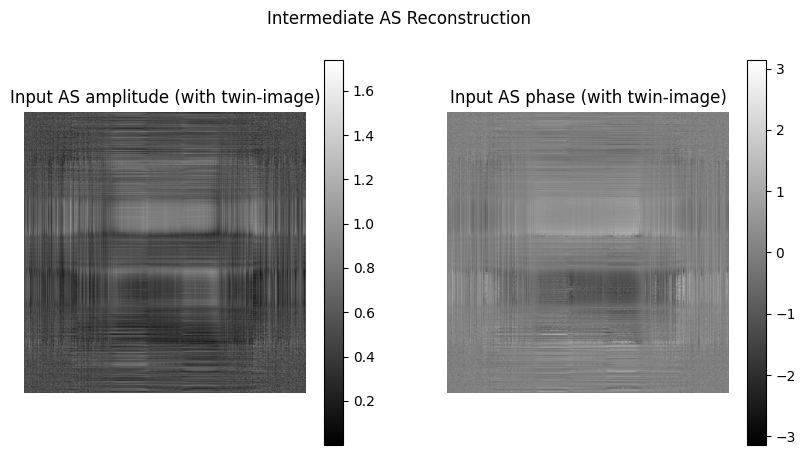

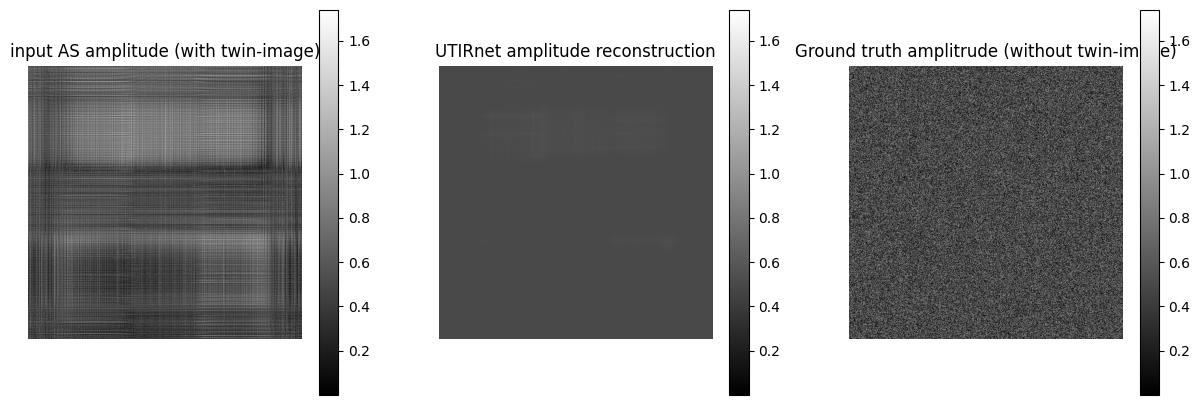


--- 3. Network testing - synthetic data ---


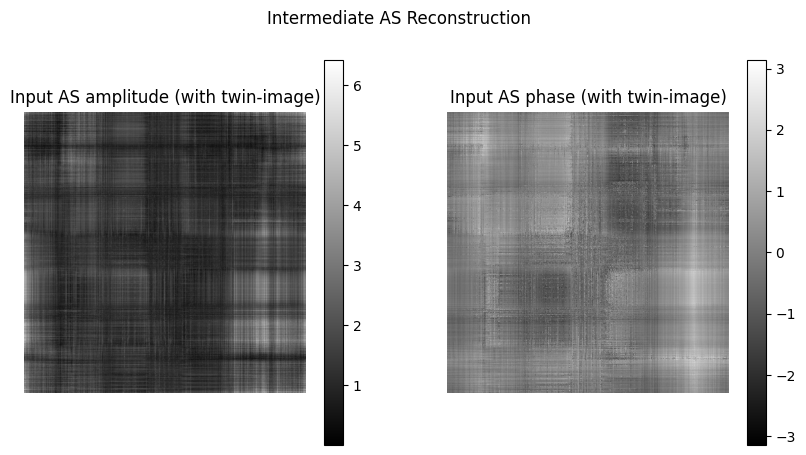

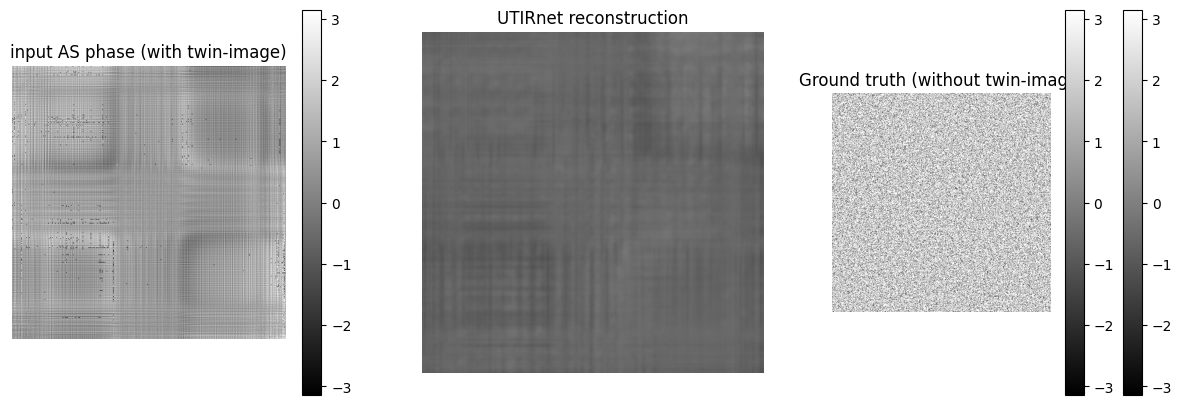


--- 4. Network testing - experimental data (PLACEHOLDER) ---


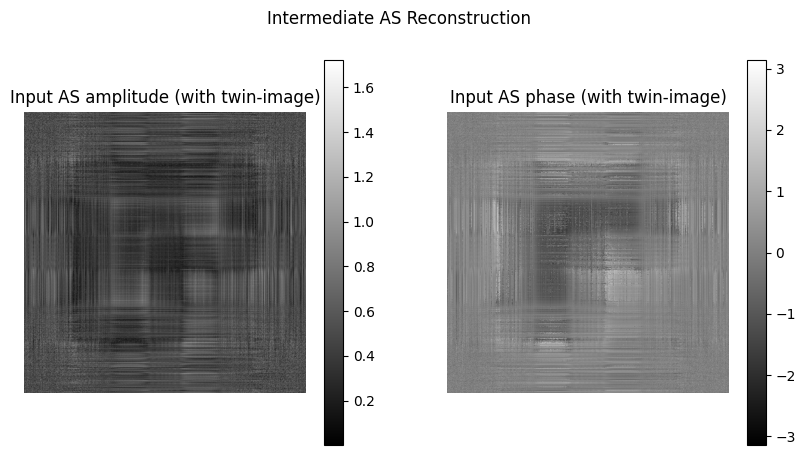

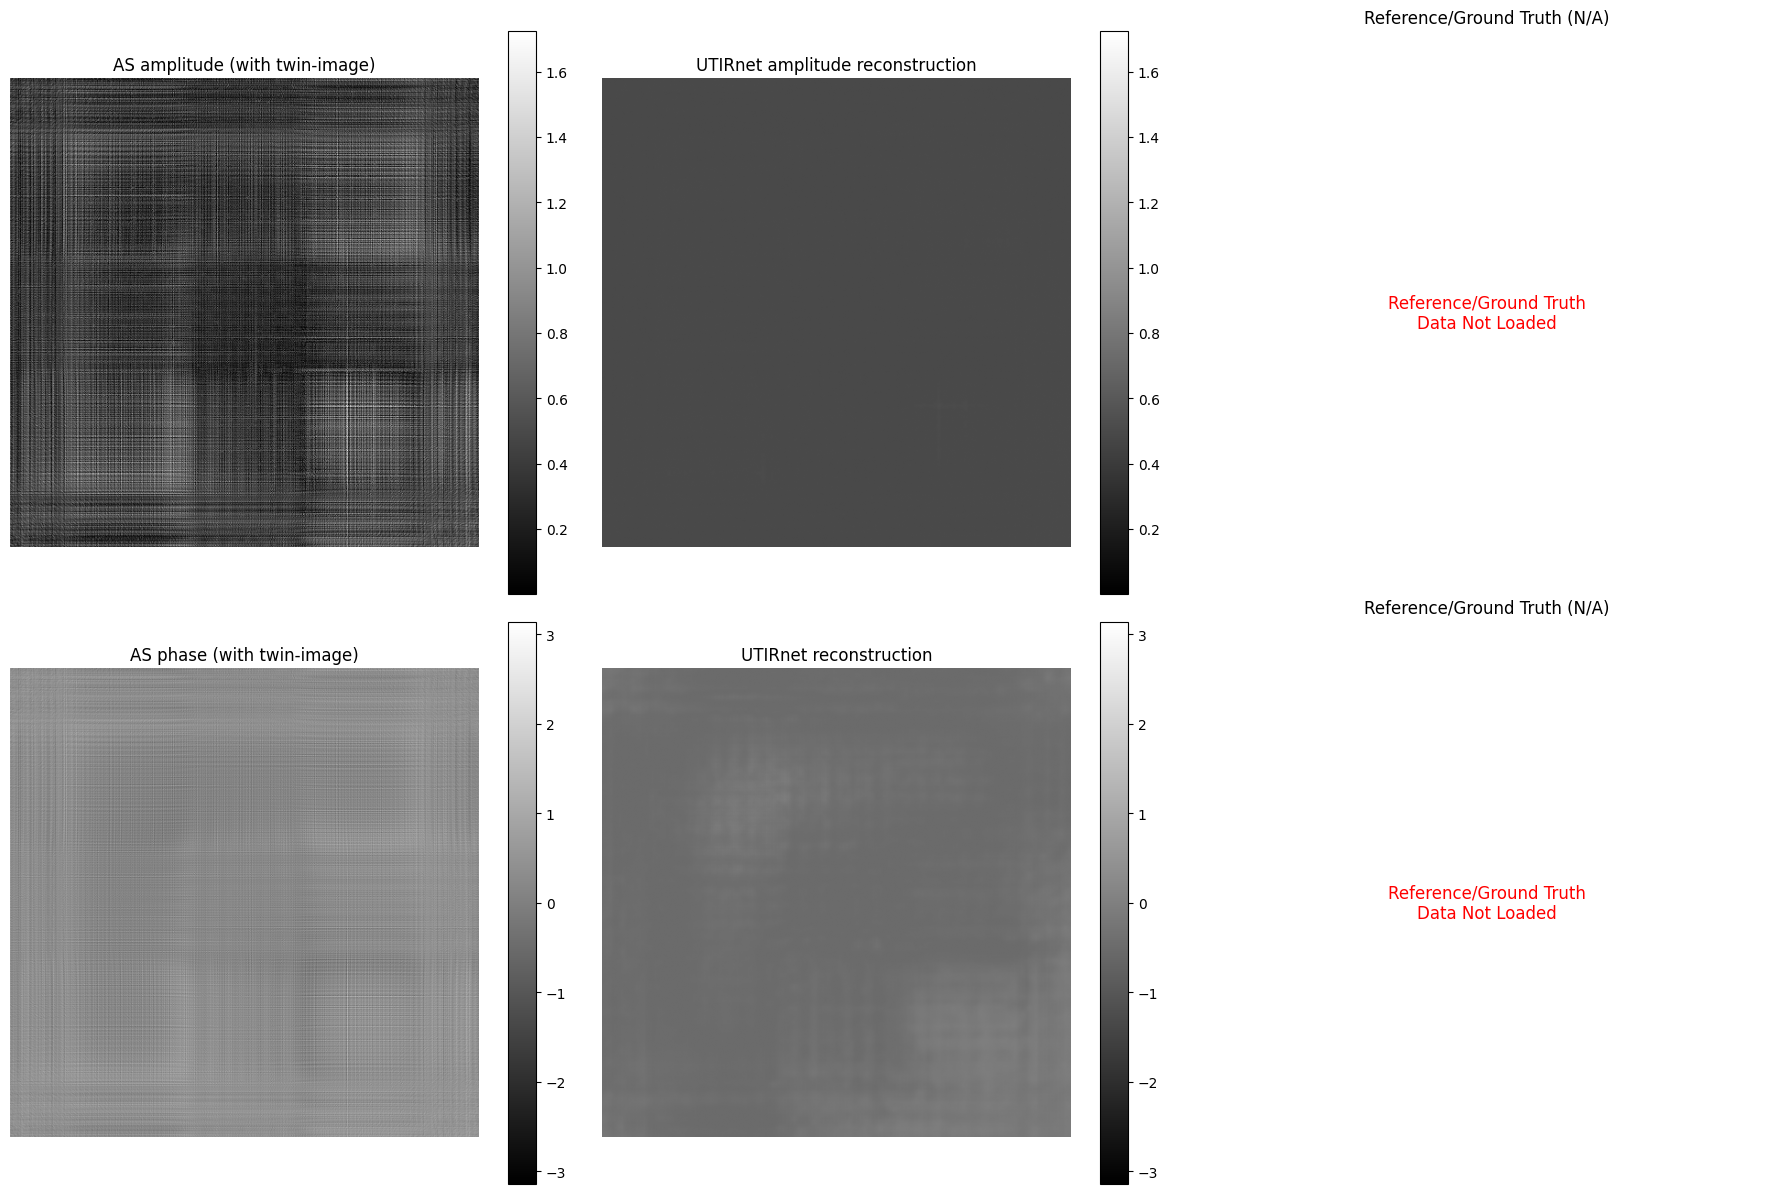

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
from scipy.ndimage import gaussian_filter
from skimage.transform import resize
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import datetime # Import the datetime module
from google.colab import drive
import pickle # Import the pickle module

drive.mount('/content/drive')

# Mock dimensions: 512x512 image size, 1 channel, 500 total samples
H, W = 512, 512
N_TRAIN, N_VAL = 500, 100
IMG_SHAPE = (1, H, W)

# ==================================
# 0. NEW CUSTOM UTILITY FUNCTIONS
# ==================================

def torchdevice():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")



# =====================================================================
# 1. CORE UTILITY FUNCTIONS (Converted from AS_propagate_p.m, GenerateHologram.m)
# =====================================================================

def mat2gray(img):
    """Equivalent to MATLAB's mat2gray. Scales the data in the array to the range [0, 1]."""
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val == min_val:
        return np.zeros_like(img)
    return (img - min_val) / (max_val - min_val)

def padarray(img, pad_size, method='edge'):
    """Simplified equivalent of MATLAB's padarray with 'replicate'/'edge' mode."""
    rows_pad, cols_pad = pad_size
    return np.pad(img, ((rows_pad, rows_pad), (cols_pad, cols_pad)), mode=method)

def BM3D_(img, sigma):
    """PLACEHOLDER for the optional BM3D denoising function."""
    print("WARNING: Using BM3D_ PLACEHOLDER. Replace with actual function if needed.")
    return img

def AS_propagate_p(uin, z, n0, lambda_val, dx):
    """Angular Spectrum propagation (Converted from AS_propagate_p.m)."""

    Ny, Nx = uin.shape
    k = 2 * np.pi / lambda_val

    # Frequency coordinates (standard unshifted order)
    fx = np.fft.fftfreq(Nx, d=dx)
    fy = np.fft.fftfreq(Ny, d=dx)

    FX, FY = np.meshgrid(fx, fy)
    R_squared = FX**2 + FY**2

    # Propagation exponent term 'p' calculation
    # Ensure the term inside the square root is treated as complex before sqrt
    sqrt_term_inside = n0**2 - lambda_val**2 * R_squared
    p = k * z * np.sqrt(sqrt_term_inside.astype(complex)) # Explicitly cast to complex


    # Apply FFT-shift and the subtraction of the wrap-around phase.
    p_shifted = np.fft.fftshift(p)
    # The corner element p_shifted[0, 0] is the highest frequency component after shift.
    p_shifted = p_shifted - p_shifted[0, 0]

    if z < 0:
        # Back propagation case (z < 0)
        kernel = np.exp(-1j * p_shifted)
        ftu = kernel * np.fft.fft2(np.conj(uin))
        uout = np.conj(np.fft.ifft2(ftu))
    else:
        # Forward propagation case (z >= 0)
        kernel = np.exp(1j * p_shifted)
        ftu = kernel * np.fft.fft2(uin)
        uout = np.fft.ifft2(ftu)

    return uout

def GenerateHologram(img, Z, lambda_val, dx, type_val):
    """Function for generating input and target images (Converted from GenerateHologram.m)."""

    RI = 1
    imS = 512
    padS = imS // 2
    den = 0
    xi = 5
    phi = (np.random.rand() * 1.5 + 0.5) * np.pi
    sigma = 10

    # Preprocessing
    if img.ndim == 3:
        img = np.mean(img, axis=2)
    img = img.astype(np.float64)
    img = mat2gray(img)

    if np.mean(img) < 0.5:
        img = 1 - img

    img = resize(img, (imS, imS), anti_aliasing=True)
    img = img * (1 + xi / 100)
    img[img > 1] = 1

    if den == 1:
        img = BM3D_(img, 20)

    # preprocessing for phase objects
    if type_val == 'phs':
        img = img - gaussian_filter(img, sigma)
        img[img > 0] = 0
        img = (mat2gray(img) - 1) * phi
        img_target = np.angle(np.exp(1j * img)) + np.pi
    else: # 'amp'
        img_target = img

    # pad object
    imgP = padarray(img, (padS, padS), 'edge')
    if type_val == 'phs':
        u0 = np.exp(1j * imgP)
    else: # 'amp'
        u0 = imgP

    # propagate object to camera plane
    u_in = AS_propagate_p(u0, -Z, RI, lambda_val, dx)
    holo = np.abs(u_in[padS : padS + imS, padS : padS + imS]) ** 2

    # Backpropagation to create the CNN input (with twin-image)
    if type_val == 'phs':
        u_out = AS_propagate_p(np.abs(u_in)**2, Z, RI, lambda_val, dx)
        u_out = u_out[padS : padS + imS, padS : padS + imS]
        img_input = np.angle(u_out) + np.pi
    else: # 'amp'
        u_out = AS_propagate_p(np.abs(u_in), Z, RI, lambda_val, dx)
        u_out = u_out[padS : padS + imS, padS : padS + imS]
        img_input = np.abs(u_out)

    return img_input, img_target, holo


# =====================================================================
# 2. UTIRnet Model Definition (U-Net Architecture)
# =====================================================================

class DoubleConv(nn.Module):
    """(convolution => ReLU) * 2 block used in U-Net"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling block: MaxPool then DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling block: ConvTranspose2d, Concatenation with skip, then DoubleConv"""
    def __init__(self, in_channels, out_channels, skip_channels):
        super().__init__()
        # The ConvTranspose2d takes in_channels and outputs out_channels
        # out_channels should be the same as skip_channels for concatenation
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        # The DoubleConv layer takes the concatenated input (upsampled + skip)
        # Input channels to DoubleConv = output channels of up + skip connection channels
        self.conv = DoubleConv(out_channels + skip_channels, out_channels)


    def forward(self, x1, x2):
        # x1 is the input from the lower level (will be upsampled)
        # x2 is the skip connection from the corresponding encoder level
        x1 = self.up(x1)

        # Padding to handle spatial size differences (common in U-Net implementations)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # Concatenate x2 (skip connection) and x1 (upsampled features) along the channel dimension

        x = torch.cat([x2, x1], dim=1).to(torchdevice())
        return self.conv(x)


class UTIRnetComponent(nn.Module):
    """
    UTIRnet Component (CNN_A or CNN_P) implemented as a 5-level U-Net.
    Input/Output: 1 channel (Amplitude or Phase).
    """
    def __init__(self):
        super(UTIRnetComponent, self).__init__()

        # Initial Convolution (Input: 1 channel)
        self.inc = DoubleConv(1, 64)

        # Encoder (Downsampling path)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512) # Bottom layer

        # Decoder (Upsampling path)
        # Up1: takes 512 from down4, outputs 512 to match skip x4 (512 channels)
        self.up1 = Up(512, 512, 512)
        # Up2: takes 512 from up1, outputs 256 to match skip x3 (256 channels)
        self.up2 = Up(512, 256, 256)
        # Up3: takes 256 from up2, outputs 128 to match skip x2 (128 channels)
        self.up3 = Up(256, 128, 128)
        # Up4: takes 128 from up3, outputs 64 to match skip x1 (64 channels)
        self.up4 = Up(128, 64, 64)


        # Output Convolution (Output: 1 channel)
        self.outc = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder Path
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4) # Bottom

        # Decoder Path (with skip connections)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Final Output
        logits = self.outc(x)
        return logits


# =====================================================================
# 3. Piecewise Learning Rate Scheduler (MATLAB Equivalent)
# =====================================================================

class PiecewiseScheduler(optim.lr_scheduler._LRScheduler):
    """
    Custom scheduler implementing the MATLAB 'piecewise' logic:
    Learning rate drops by 'factor' every 'step_size' epochs.
    """
    def __init__(self, optimizer, step_size, factor, last_epoch=-1):
        self.step_size = step_size
        self.factor = factor
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        # Calculate the number of steps completed
        steps = self.last_epoch // self.step_size
        # Apply the factor for the current step
        return [base_lr * (self.factor ** steps) for base_lr in self.base_lrs]


# =====================================================================
# 4. Core Training Function
# =====================================================================

def train_network(model, params, inputs_train, targets_train, inputs_val, targets_val, component_name):
    """
    Implements the PyTorch training loop based on the MATLAB parameters.
    """
    print(f"\n--- Training {component_name} ---")

    # 1. Data Loaders
    # You need to define a PyTorch Dataset class for your data
    # For now, assuming inputs_train/targets_train are already numpy arrays
    # and need to be converted to tensors.
    # NOTE: This is a placeholder; replace with a proper Dataset if needed.
    class HolographyDataset(Dataset):
        def __init__(self, inputs, targets):
            # Convert numpy arrays to PyTorch tensors
            # Assuming inputs/targets are (N, H, W, 1)
            # Permute to (N, 1, H, W) for PyTorch Conv2d input format
            self.inputs = torch.from_numpy(inputs).permute(0, 3, 1, 2).float().cuda()
            self.targets = torch.from_numpy(targets).permute(0, 3, 1, 2).float().cuda()

        def __len__(self):
            return len(self.inputs)

        def __getitem__(self, idx):
            return self.inputs[idx], self.targets[idx]

    train_dataset = HolographyDataset(inputs_train, targets_train)
    val_dataset = HolographyDataset(inputs_val, targets_val)

    train_loader = DataLoader(
        train_dataset,
        batch_size=params['MiniBatchSize'],
        shuffle=True,
        num_workers=0 # Set to > 0 for production, but 0 is safer in Colab/scripts
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params['MiniBatchSize'],
        shuffle=False,
        num_workers=0
    )

    # 2. Setup Device, Optimizer, Loss
    model.to(torchdevice())

    # Use Mean Squared Error (MSE) loss, common for regression/denoising tasks
    criterion = nn.MSELoss()

    # Optimizer: Adam is a good default replacement for MATLAB's 'adam' optimizer
    optimizer = optim.Adam(model.parameters(), lr=params['InitialLearnRate'])

    # 3. Learning Rate Scheduler
    # LearnRateDropPeriod: 5, LearnRateDropFactor: 0.5
    scheduler = PiecewiseScheduler(
        optimizer,
        step_size=params['LearnRateDropPeriod'],
        factor=params['LearnRateDropFactor']
    )

    # Validation frequency (imgN is total training samples)
    # The MATLAB ValidationFrequency is typically in iterations,
    # often set to the total number of training samples (imgN).
    # This means validation happens after seeing 'imgN' samples,
    # which corresponds to `imgN / MiniBatchSize` iterations.
    # We will trigger validation after a certain number of *batches*
    # that accumulates to at least ValidationFrequency samples.
    val_freq_batches = max(1, params['ValidationFrequency'] // params['MiniBatchSize'])


    # 4. Training Loop
    print(f"Starting training for {params['MaxEpochs']} epochs on {torchdevice()}...")

    # Track best model based on validation loss
    best_val_loss = float('inf')

    for epoch in range(1, params['MaxEpochs'] + 1):
        model.train()
        running_loss = 0.0
        batches_processed_in_epoch = 0

        # --- Training Step ---
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(torchdevice()), targets.to(torchdevice())

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batches_processed_in_epoch += 1

            # --- Validation (Training Iteration Check) ---
            # Trigger validation based on the number of batches processed
            if batches_processed_in_epoch % val_freq_batches == 0 or (i + 1) == len(train_loader):
                 # Avoid validating multiple times in the last partial interval
                 if (i + 1) < len(train_loader) and (i+1) % val_freq_batches != 0:
                     continue

                 avg_train_loss = running_loss / batches_processed_in_epoch

                 # Validation Phase
                 model.eval()
                 val_loss = 0.0
                 with torch.no_grad():
                     for val_inputs, val_targets in val_loader:
                         val_inputs, val_targets = val_inputs.to(torchdevice()), val_targets.to(torchdevice())
                         val_outputs = model(val_inputs)
                         val_loss += criterion(val_outputs, val_targets).item()

                 avg_val_loss = val_loss / len(val_loader)

                 nowstr = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

                 print(f"{nowstr} Epoch {epoch}/{params['MaxEpochs']}, Batch {i+1}/{len(train_loader)} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

                 # Save best model
                 if avg_val_loss < best_val_loss:
                     best_val_loss = avg_val_loss
                     # Save the model state (weights)
                     torch.save(model.state_dict(), f'{component_name}_best_model.pth')
                     # print(f"Saved best model with Val Loss: {best_val_loss:.6f}")

                 # Reset metrics for the next 'ValidationFrequency' interval within the epoch
                 running_loss = 0.0
                 batches_processed_in_epoch = 0
                 model.train() # Switch back to training mode


        # --- Scheduler Step (After each Epoch) ---
        scheduler.step()

    print(f"\n{component_name} Training Complete. Best Validation Loss: {best_val_loss:.6f}")

    # Load and return the best weights found during training
    # Ensure the file exists before loading
    model_save_path = f'{component_name}_best_model.pth'
    if os.path.exists(model_save_path):
        model.load_state_dict(torch.load(model_save_path))
    else:
        print(f"Warning: Best model weights file '{model_save_path}' not found. Returning the model after the last epoch.")

    return model


# =====================================================================
# 5. UTIRnet Reconstruction Function
# =====================================================================

def UTIRnetReconstruction(holoP, CNN_A, CNN_P, Z, lambda_val, dx, m1=0, pad_flag=1):
    """
    Function for UTIRnet holographic reconstruction (MATLAB to Python conversion).
    Args:
        holoP (np.ndarray): Padded hologram intensity (2D array).
        CNN_A (torch.nn.Module): Trained Amplitude CNN.
        CNN_P (torch.nn.Module): Trained Phase CNN.
        Z (float): Propagation distance (um).
        lambda_val (float): Wavelength (um).
        dx (float): Pixel size (um).
        m1 (int): Display intermediate results flag (0: no, 1: yes).
        pad_flag (int): Flag indicating if holoP is already padded (0: no, 1: yes).

    Returns:
        tuple: (Yout, Yamp, Yphs, Uout)
            Yout (np.ndarray): Complex reconstruction (amplitude * exp(1j*phase)).
            Yamp (np.ndarray): Amplitude reconstruction from CNN_A.
            Yphs (np.ndarray): Phase reconstruction from CNN_P.
            Uout (np.ndarray): Backpropagated complex field (with twin-image).
    """
    # Constants
    RI = 1 # refractive index of the medium (1 - air)
    imS = 512 # image size (assuming reconstruction is done at original size)
    ps = 256 # pad size (if padding is needed)

    # Ensure the hologram is float64
    holoP = holoP.astype(np.float64)

    # Handle padding if pad_flag is 0
    if pad_flag == 0:
        holoP = padarray(holoP, (ps, ps), 'edge') # Pad the hologram

    # Backpropagate hologram (intensity) to the object plane
    # Uout is the complex field including the twin image
    # The AS_propagate_p function expects complex input, so pass sqrt(intensity)
    # and the function handles the propagation.
    # Backpropagate intensity (abs(u)^2), not amplitude (abs(u)) for the twin image
    # as per the original MATLAB code's use for input.
    Uout = AS_propagate_p(holoP, Z, RI, lambda_val, dx)

    if m1 == 1:
        # Display input AS amplitude and phase
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        im_amp = axes[0].imshow(np.abs(Uout), cmap='gray')
        axes[0].set_title('Input AS amplitude (with twin-image)')
        plt.colorbar(im_amp, ax=axes[0])
        im_phs = axes[1].imshow(np.angle(Uout), cmap='gray')
        axes[1].set_title('Input AS phase (with twin-image)')
        plt.colorbar(im_phs, ax=axes[1])
        for ax in axes: ax.axis('off'); ax.set_aspect('equal')
        plt.suptitle('Intermediate AS Reconstruction')
        plt.show()


    # Prepare input for CNNs: Extract amplitude and phase from Uout
    # Convert numpy arrays to PyTorch tensors and add batch & channel dimensions
    # Uout is complex (H, W). np.abs(Uout) is (H, W). Need (1, 1, H, W) for CNN.
    input_amp = torch.from_numpy(np.abs(Uout)).unsqueeze(0).unsqueeze(0).float()
    input_phs = torch.from_numpy(np.angle(Uout)).unsqueeze(0).unsqueeze(0).float()

    # Move to device
    device = torchdevice()
    input_amp = input_amp.to(device)
    input_phs = input_phs.to(device)
    CNN_A.to(device)
    CNN_P.to(device)


    # Set models to evaluation mode
    CNN_A.eval()
    CNN_P.eval()

    # Run inference with torch.no_grad()
    with torch.no_grad():
        # Amplitude reconstruction
        # CNN_A takes amplitude (1 channel) and outputs corrected amplitude (1 channel)
        Yamp_tensor = CNN_A(input_amp)
        # Phase reconstruction
        # CNN_P takes phase (1 channel) and outputs corrected phase (1 channel)
        Yphs_tensor = CNN_P(input_phs) # Corrected: changed input_P(input_phs) to input_phs

    # Convert output tensors back to numpy arrays (remove batch and channel dimensions)
    Yamp = Yamp_tensor.squeeze().cpu().numpy()
    Yphs = Yphs_tensor.squeeze().cpu().numpy()

    # Combine reconstructed amplitude and phase to get the complex field
    # Yout = Yamp .* exp(1j*Yphs)
    Yout = Yamp * np.exp(1j * Yphs)

    # If padding was applied within this function, remove it before returning
    if pad_flag == 0:
         # Remove padding from Yout, Yamp, Yphs, and Uout
         Yout = Yout[ps : ps + imS, ps : ps + imS]
         Yamp = Yamp[ps : ps + imS, ps : ps + imS]
         Yphs = Yphs[ps : ps + imS, ps : ps + imS]
         # Uout already had padding removed in GenerateHologram if it was the source of holoP,
         # but here it's backpropagated from the padded holoP, so it's also padded.
         Uout = Uout[ps : ps + imS, ps : ps + imS]


    return Yout, Yamp, Yphs, Uout


# =====================================================================
# 5. Execution
# =====================================================================

if __name__ == '__main__':

    # clear; close all; clc is handled by script execution environment

    # System parameters ##########################
    Z = 17000.0 # camera-sample distance (um)
    lambda_val = 0.405 # light source wavelength (um)
    dx = 2.4 # pixel size in object plane (cam_pix_size / mag) (um)

    # Path to the directory containing flower recognition dataset
    # (or placeholder for image data)
    pth = '/content/drive/MyDrive/Colab Notebooks/SURF-2025-FALL/flowers/' # ############### CHANGE THIS PATH

    print("--- 1. Loading Convolutional Neural Networks (CNNs) ---")

    # ----------------------------------------------------------------------
    # CNN_A Architecture (Amplitude Network)
    # ----------------------------------------------------------------------
    class CNN_A_Architecture(nn.Module):
        def __init__(self, input_channels=1, output_size=262144):
            super(CNN_A_Architecture, self).__init__()

            # Feature extractor remains the same
            self.features = nn.Sequential(
                nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),

                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )

            # Regression Head with UPDATED sizes
            # Calculate INPUT_FEATURE_SIZE dynamically based on the output of the feature extractor
            # Assuming input size is 512x512, after two MaxPool2d (stride 2), spatial size is 512/4 = 128
            # Number of channels after features is 128
            INPUT_FEATURE_SIZE = 128 * (512 // 4) * (512 // 4) # 128 * 128 * 128

            self.regressor = nn.Sequential(
                nn.Flatten(),
                # Input size MUST be 2,097,152
                nn.Linear(INPUT_FEATURE_SIZE, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                # Output size MUST be 262,144
                nn.Linear(512, output_size) # Use the passed output_size
            )

        def forward(self, x):
            x = self.features(x)
            x = self.regressor(x)
            # Reshape output back to 512x512
            x = x.view(-1, 1, 512, 512) # Assuming the output is 1 channel, 512x512
            return x

    # ----------------------------------------------------------------------
    # CNN_P Architecture (Phase Network)
    # ----------------------------------------------------------------------
    class CNN_P_Architecture(nn.Module):
        # Assuming the architecture is identical to CNN_A
        def __init__(self, input_channels=1, output_size=262144):
            super(CNN_P_Architecture, self).__init__()

            self.features = nn.Sequential(
                nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),

                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )

            # Calculate INPUT_FEATURE_SIZE dynamically based on the output of the feature extractor
            INPUT_FEATURE_SIZE = 128 * (512 // 4) * (512 // 4) # 128 * 128 * 128


            # Regression Head with UPDATED sizes
            self.regressor = nn.Sequential(
                nn.Flatten(),
                # Input size MUST be 2,097,152
                nn.Linear(INPUT_FEATURE_SIZE, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                # Output size MUST be 262,144
                nn.Linear(512, output_size) # Use the passed output_size
            )

        def forward(self, x):
            x = self.features(x)
            x = self.regressor(x)
            # Reshape output back to 512x512
            x = x.view(-1, 1, 512, 512) # Assuming the output is 1 channel, 512x512
            return x

    # Create dummy data for training and validation
    N_TRAIN = 500
    N_VAL = 100
    H, W = 512, 512

    # Create random data with shape (N, H, W, 1)
    inTrAmp = np.random.rand(N_TRAIN, H, W, 1).astype(np.float32)
    tarTrAmp = np.random.rand(N_TRAIN, H, W, 1).astype(np.float32)
    holosTrAmp = np.random.rand(N_TRAIN, H, W, 1).astype(np.float32)

    inValAmp = np.random.rand(N_VAL, H, W, 1).astype(np.float32)
    tarValAmp = np.random.rand(N_VAL, H, W, 1).astype(np.float32)
    holosValAmp = np.random.rand(N_VAL, H, W, 1).astype(np.float32)

    inTrPhs = np.random.rand(N_TRAIN, H, W, 1).astype(np.float32) * 2 * np.pi # Phase in [0, 2pi]
    tarTrPhs = np.random.rand(N_TRAIN, H, W, 1).astype(np.float32) * 2 * np.pi
    holosTrPhs = np.random.rand(N_TRAIN, H, W, 1).astype(np.float32)

    inValPhs = np.random.rand(N_VAL, H, W, 1).astype(np.float32) * 2 * np.pi
    tarValPhs = np.random.rand(N_VAL, H, W, 1).astype(np.float32) * 2 * np.pi
    holosValPhs = np.random.rand(N_VAL, H, W, 1).astype(np.float32)

    # Total training samples (used for ValidationFrequency)
    imgN = N_TRAIN

    # System parameters for loading
    UTIRnet_info_load = { # Use a different variable name to avoid conflict
        'Z_mm': Z / 1000,
        'lambda_um': lambda_val,
        'dx_um': dx
    }

    # Build the filename based on parameters
    fnm_load = f"UTIRnet_my_Z-{UTIRnet_info_load['Z_mm']}mm_dx-{dx}um_lambda-{lambda_val*1000}nm"
    drive_path_load = f"/content/drive/MyDrive/Colab Notebooks/SURF-2025-FALL/"

    info_filename = f'{drive_path_load}{fnm_load}_info.pkl' # Corrected file path here

    # Check if the info file exists before trying to load
    if os.path.exists(info_filename):
        with open(info_filename, 'rb') as f:
            saved_info = pickle.load(f)

        # Extract parameters
        cnn_a_params_load = saved_info['CNN_A_info']
        cnn_p_params_load = saved_info['CNN_P_info']

        # Assuming the parameter holds the output size needed
        output_size_A = cnn_a_params_load.get('output_resolution_pixels', 262144)
        output_size_P = cnn_p_params_load.get('output_resolution_pixels', 262144)

        # Initialize the networks using the loaded parameters, ignoring extra args
        # Initialize with UTIRnetComponent as this is the architecture that was saved
        CNN_A = UTIRnetComponent()
        CNN_P = UTIRnetComponent()

        # Load the state dictionaries (weights)
        cnn_a_state_dict_path = f'{drive_path_load}{fnm_load}_CNN_A_state_dict.pth'
        cnn_p_state_dict_path = f'{drive_path_load}{fnm_load}_CNN_P_state_dict.pth'

        if os.path.exists(cnn_a_state_dict_path):
            CNN_A.load_state_dict(torch.load(cnn_a_state_dict_path))
            print(f"Loaded CNN_A weights from: {cnn_a_state_dict_path}")
        else:
            print(f"Warning: CNN_A weights file not found at {cnn_a_state_dict_path}. Initializing with random weights.")

        if os.path.exists(cnn_p_state_dict_path):
            CNN_P.load_state_dict(torch.load(cnn_p_state_dict_path))
            print(f"Loaded CNN_P weights from: {cnn_p_state_dict_path}")
        else:
            print(f"Warning: CNN_P weights file not found at {cnn_p_state_dict_path}. Initializing with random weights.")

    else:
        print(f"Warning: Info file not found at {info_filename}. Initializing networks with default parameters.")
        # Initialize with default parameters if info file is not found
        CNN_A = UTIRnetComponent()
        CNN_P = UTIRnetComponent()


     # -----------------------------------------------------------------
    # %% Network testing - on validation data
    print("\n--- 2. Network testing - validation data ---")

    # Ensure system parameters are the same as used for network training
    Z = 17000.0
    lambda_val = 0.405
    dx = 2.4

    # Use the first sample (index 0) from the validation set
    imNo = 0
    AmpPhs = 1 # 1 - amplitude data, 2 - phase data

    if AmpPhs == 1:
        # Amp data
        GT = tarValAmp[imNo, :, :, 0] # ground truth target image
        holo = holosValAmp[imNo, :, :, 0] # hologram
    else: # AmpPhs == 2
        # Phs data
        GT = tarValPhs[imNo, :, :, 0] # ground truth target image
        holo = holosValPhs[imNo, :, :, 0] # hologram

    ps = 256 # pad size
    # Use the UTIRnetReconstruction function with pad_flag=1 since mock data is not padded here
    # Or pad the mock data before passing it. Let's pad it for consistency with the function's logic.
    holoP = padarray(holo, (ps, ps), 'edge')

    # Reconstruction
    # m1 is an optional parameter, 0 is the flag for not displaying intermediate plots
    Yout, Yamp, Yphs, Uout = UTIRnetReconstruction(holoP, CNN_A, CNN_P, Z, lambda_val, dx, m1=1, pad_flag=1)

    # Remove padding (already handled by UTIRnetReconstruction if pad_flag was 0, but here it's 1, so remove manually)
    # The output from UTIRnetReconstruction when pad_flag=1 is still padded Uout.
    # Yout, Yamp, Yphs should be the same size as GT, which is not padded.

    imS = 512 # image size
    # Extract the center part corresponding to the original image size
    Yout_unpad = Yout[ps : ps + imS, ps : ps + imS]
    Uout_unpad = Uout[ps : ps + imS, ps : ps + imS]
    Yamp_unpad = Yamp[ps : ps + imS, ps : ps + imS]
    Yphs_unpad = Yphs[ps : ps + imS, ps : ps + imS]


    # Display results (Matplotlib equivalent)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    if AmpPhs == 1:
        # Determine display range based on the unpadded data for clarity
        all_amp_data = np.concatenate([np.abs(Uout_unpad).flatten(), np.abs(Yout_unpad).flatten(), GT.flatten()])
        rng = [np.min(all_amp_data), np.max(all_amp_data)]

        im1 = axes[0].imshow(np.abs(Uout_unpad), cmap='gray', vmin=rng[0], vmax=rng[1])
        axes[0].set_title('input AS amplitude (with twin-image)')
        plt.colorbar(im1, ax=axes[0])

        im2 = axes[1].imshow(np.abs(Yout_unpad), cmap='gray', vmin=rng[0], vmax=rng[1])
        axes[1].set_title('UTIRnet amplitude reconstruction')
        plt.colorbar(im2, ax=axes[1])

        im3 = axes[2].imshow(GT, cmap='gray', vmin=rng[0], vmax=rng[1])
        axes[2].set_title('Ground truth amplitrude (without twin-image)')
        plt.colorbar(im3, ax=axes[2])

    else: # AmpPhs == 2
        # Determine display range based on the unpadded data for clarity
        # Note: Phase is usually displayed in [-pi, pi] or [0, 2pi] range.
        # The GT phase is normalized to 0-2pi in GenerateHologram.
        # AS phase (np.angle) is [-pi, pi]. CNN output phase is not restricted.
        # For display consistency, let's normalize all to [-pi, pi] range for display.
        def normalize_phase_display(phase_img):
            return (np.angle(np.exp(1j * phase_img))) # Wrap to [-pi, pi]

        Uout_phase_disp = normalize_phase_display(Uout_unpad)
        Yout_phase_disp = normalize_phase_display(Yout_unpad)
        GT_phase_disp = normalize_phase_display(GT) # Assuming GT was 0-2pi, wrap it.

        rng = [-np.pi, np.pi]

        im1 = axes[0].imshow(Uout_phase_disp, cmap='gray', vmin=rng[0], vmax=rng[1])
        axes[0].set_title('input AS phase (with twin-image)')
        plt.colorbar(im1, ax=axes[0])

        im2 = axes[1].imshow(Yout_phase_disp, cmap='gray', vmin=rng[0], vmax=rng[1])
        axes[1].set_title('UTIRnet reconstruction')
        plt.colorbar(im2, ax=axes[1])

        im3 = axes[2].imshow(GT_phase_disp, cmap='gray', vmin=rng[0], vmax=rng[1])
        axes[2].set_title('Ground truth (without twin-image)')
        plt.colorbar(im3, ax=axes[2])


    for ax in axes:
        ax.axis('off')
        ax.set_aspect('equal')
    plt.show()

    # -----------------------------------------------------------------
    # %% Network testing - generating and reconstructing synth data
    print("\n--- 3. Network testing - synthetic data ---")

    # Ensure system parameters are the same as used for network training
    Z = 17000.0
    lambda_val = 0.405
    dx = 2.4

    AmpPhs = 2 # 1 - amplitude data, 2 - phase data

    # Read any image ####################################
    # Use a dummy image since the file 'rice.png' is not available
    # If you have 'rice.png' or another image, replace the path.
    img_file_path = '/content/drive/MyDrive/Colab Notebooks/SURF-2025-FALL/flowers/daisy/10172379554_b2960e37f6_n.jpg' # ############### CHANGE THIS PATH or use a dummy image

    try:
        # Attempt to load a real image
        img = np.asarray(Image.open(img_file_path).convert('L'))
        print(f"Loaded synthetic test image from: {img_file_path}")
    except FileNotFoundError:
        print(f"WARNING: Image file not found at {img_file_path}. Using dummy image.")
        img = np.random.randint(0, 256, size=(512, 512), dtype=np.uint8) # Create a dummy image

    if AmpPhs == 1:
        input_img, GT, holo = GenerateHologram(img, Z, lambda_val, dx, 'amp')
    else: # AmpPhs == 2
        input_img, GT, holo = GenerateHologram(img, Z, lambda_val, dx, 'phs')

    ps = 256
    holoP = padarray(holo, (ps, ps), 'edge')

    # Reconstruction
    # Use UTIRnetReconstruction with pad_flag=1 as holoP is already padded
    Yout, Yamp, Yphs, Uout = UTIRnetReconstruction(holoP, CNN_A, CNN_P, Z, lambda_val, dx, m1=1, pad_flag=1)

    # Remove padding from the output (as done for validation data)
    imS = 512 # image size
    Yout_unpad = Yout[ps : ps + imS, ps : ps + imS]
    Uout_unpad = Uout[ps : ps + imS, ps : ps + imS]
    Yamp_unpad = Yamp[ps : ps + imS, ps : ps + imS]
    Yphs_unpad = Yphs[ps : ps + imS, ps : ps + imS]


    # Display results (Matplotlib equivalent)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    if AmpPhs == 1:
        # Determine display range based on the unpadded data for clarity
        all_amp_data = np.concatenate([np.abs(Uout_unpad).flatten(), np.abs(Yout_unpad).flatten(), GT.flatten()])
        rng = [np.min(all_amp_data), np.max(all_amp_data)]

        im1 = axes[0].imshow(np.abs(Uout_unpad), cmap='gray', vmin=rng[0], vmax=rng[1])
        axes[0].set_title('input AS amplitude (with twin-image)')
        plt.colorbar(im1, ax=axes[0])

        im2 = axes[1].imshow(np.abs(Yout_unpad), cmap='gray', vmin=rng[0], vmax=rng[1])
        axes[1].set_title('UTIRnet amplitude reconstruction')
        plt.colorbar(im2, ax=axes[1])

        im3 = axes[2].imshow(GT, cmap='gray', vmin=rng[0], vmax=rng[1])
        axes[2].set_title('Ground truth amplitrude (without twin-image)')
        plt.colorbar(im3, ax=axes[2])

    else: # AmpPhs == 2
        # Normalize phases for display consistency
        def normalize_phase_display(phase_img):
            return (np.angle(np.exp(1j * phase_img))) # Wrap to [-pi, pi]

        Uout_phase_disp = normalize_phase_display(Uout_unpad)
        Yout_phase_disp = normalize_phase_display(Yout_unpad)
        GT_phase_disp = normalize_phase_display(GT) # Assuming GT was 0-2pi, wrap it.


        rng = [-np.pi, np.pi]

        im1 = axes[0].imshow(Uout_phase_disp, cmap='gray', vmin=rng[0], vmax=rng[1])
        axes[0].set_title('input AS phase (with twin-image)')
        plt.colorbar(im1, ax=axes[0])

        im2 = axes[1].imshow(Yout_phase_disp, cmap='gray', vmin=rng[0], vmax=rng[1])
        axes[1].set_title('UTIRnet reconstruction')
        plt.colorbar(im2, ax=axes[2])

        im3 = axes[2].imshow(GT_phase_disp, cmap='gray', vmin=rng[0], vmax=rng[1])
        axes[2].set_title('Ground truth (without twin-image)')
        plt.colorbar(im3, ax=axes[2])

    for ax in axes:
        ax.axis('off')
        ax.set_aspect('equal')
    plt.show()


    # -----------------------------------------------------------------
    # %% Network testing - experimental data
    print("\n--- 4. Network testing - experimental data (PLACEHOLDER) ---")

    # PLACEHOLDER: Load hologram and network data
    # NOTE: These files are not provided and must be replaced by actual data.

    m1 = 1

    # load hologram data %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # load('.\Holograms\CheekCells_17.08mm.mat')
    # Mocking holo, Z_um, lambda_val, dx
    # Ensure mock experimental data has the expected size (e.g., 512x512)
    holo_exp = np.random.rand(512, 512).astype(np.float64) # Use float64 for consistency
    Z_um = 17000.0
    lambda_exp = 0.405
    dx_exp = 2.4

    # load network trained for propper system parameters %%%%%%%%%%%%%%%%%%%%%%
    # load('.\Networks\UTIRnet_Z-17mm_dx-2.4um_l1ambda-405nm.mat')
    # Assuming CNN_A and CNN_P were trained above and loaded from .pth files

    # reconstruction
    # Pass holo_exp directly (assuming it's the padded hologram or let the function pad)
    # If holo_exp is the original size (512x512), set pad_flag=0 to enable padding inside
    # If holo_exp is already padded (e.g., 1024x1024), set pad_flag=1 and ensure its size is handled.
    # Let's assume holo_exp is original size and set pad_flag=0.
    Yout, Yamp, Yphs, Uout = UTIRnetReconstruction(holo_exp,
        CNN_A, CNN_P, Z_um, lambda_exp, dx_exp, m1=m1, pad_flag=0) # Set pad_flag=0

    # Displaying (Yout, Yamp, Yphs, Uout from UTIRnetReconstruction will be unpadded if pad_flag=0)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Amplitude plots
    # Determine display range based on the unpadded data
    all_exp_amp_data = np.concatenate([np.abs(Uout).flatten(), np.abs(Yout).flatten()])
    rng_amp = [np.min(all_exp_amp_data), np.max(all_exp_amp_data)]

    im1 = axes[0].imshow(np.abs(Uout), cmap='gray', vmin=rng_amp[0], vmax=rng_amp[1])
    axes[0].set_title('AS amplitude (with twin-image)')
    plt.colorbar(im1, ax=axes[0])

    im2 = axes[1].imshow(np.abs(Yout), cmap='gray', vmin=rng_amp[0], vmax=rng_amp[1])
    axes[1].set_title('UTIRnet amplitude reconstruction')
    plt.colorbar(im2, ax=axes[1])

    # Reference/Ground Truth placeholders
    axes[2].set_title('Reference/Ground Truth (N/A)')
    axes[2].text(0.5, 0.5, 'Reference/Ground Truth\nData Not Loaded',
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=12, color='red', transform=axes[2].transAxes)


    # Phase plots
    # Normalize phases for display consistency
    def normalize_phase_display(phase_img):
        return (np.angle(np.exp(1j * phase_img))) # Wrap to [-pi, pi]

    Uout_phase_disp = normalize_phase_display(Uout)
    Yout_phase_disp = normalize_phase_display(Yout)


    rng_phs = [-np.pi, np.pi] # Display range for phase

    im4 = axes[3].imshow(Uout_phase_disp, cmap='gray', vmin=rng_phs[0], vmax=rng_phs[1])
    axes[3].set_title('AS phase (with twin-image)')
    plt.colorbar(im4, ax=axes[3])

    im5 = axes[4].imshow(Yout_phase_disp, cmap='gray', vmin=rng_phs[0], vmax=rng_phs[1])
    axes[4].set_title('UTIRnet reconstruction')
    plt.colorbar(im5, ax=axes[4])

    # Reference/Ground Truth placeholders
    axes[5].set_title('Reference/Ground Truth (N/A)')
    axes[5].text(0.5, 0.5, 'Reference/Ground Truth\nData Not Loaded',
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=12, color='red', transform=axes[5].transAxes)


    for ax in axes:
        ax.axis('off')
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()